In [246]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

from shapely.ops import unary_union
from shapely import wkt

In [247]:
date = "2024-03-06"
period = 15

root = Path.cwd().parent / "resources" / 'live_data' / '{}_{}'.format(date, period)

In [248]:
# n = pypsa.Network(root / 'network_s_nodal.nc')
# n = pypsa.Network(root.parent.parent / 'networks' / 'gen.nc')
n = pypsa.Network(root.parent.parent.parent / 'data' / 'base.nc')

regions = gpd.read_file(Path.cwd().parent / 'data' / 'fti_zones.geojson').set_index('name')['geometry']

INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, transformers


In [249]:
regions = gpd.GeoDataFrame(geometry=[unary_union(regions.buffer(0.01))])

C:\Users\lukas\AppData\Local\Temp\ipykernel_25460\921544858.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions = gpd.GeoDataFrame(geometry=[unary_union(regions.buffer(0.01))])


In [250]:
buses = gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y))
buses = buses.loc[buses.geometry.within(regions.geometry[0])]

In [251]:
lines = gpd.GeoDataFrame(n.lines, geometry=[wkt.loads(x) for x in n.lines.geometry]).set_crs(epsg=4326)
lines = lines.loc[lines.bus0.isin(buses.index) & lines.bus1.isin(buses.index)]
links = gpd.GeoDataFrame(n.links, geometry=[wkt.loads(x) for x in n.links.geometry]).set_crs(epsg=4326)
links = links.loc[links.bus0.isin(buses.index) & links.bus1.isin(buses.index)]

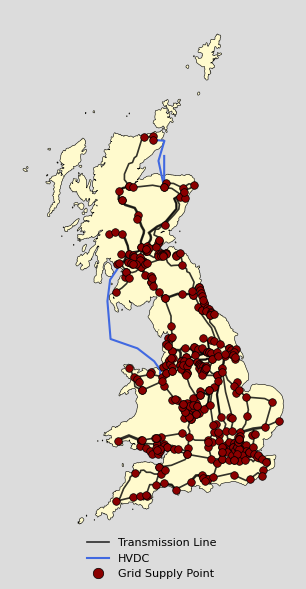

In [252]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Circle

size = (7, 7)
background_color = 'gainsboro'

fig, ax = plt.subplots(1, 1, figsize=size)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

handles, labels = [], []

regions.plot(ax=ax, edgecolor='black', facecolor='lemonchiffon', alpha=1, zorder=0, linewidth=0.4)

line_kwargs = dict(linewidth=1.2, alpha=0.8, zorder=1, color='black')
lines.plot(ax=ax, **line_kwargs)

handles.append(Line2D([0], [0], **line_kwargs))
labels.append("Transmission Line")

link_kwargs = dict(linewidth=1.5, color='royalblue')
links.plot(ax=ax, zorder=1, **link_kwargs)

handles.append(Line2D([0], [0], **link_kwargs))
labels.append("HVDC")

s = 30
gsp_kwargs = dict(s=s, edgecolor='black', alpha=1, linewidth=0.5, color='darkred')
ax.scatter(buses.x, buses.y, **gsp_kwargs)

handles.append(
    Line2D(
        [], [],
        color=background_color,
        marker='o',
        markersize=s/4,
        markerfacecolor='darkred',
        markeredgewidth=0.5,
        markeredgecolor='black',
        )
    )
labels.append("Grid Supply Point")

ax.legend(
    handles,
    labels,
    # loc='lower center',
    fontsize=8,
    borderpad=0,
    labelspacing=0.5,
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0.74, 0.03),
    )

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('network_layout.png', dpi=300)

plt.show()

In [237]:
print(links.crs)
print(regions.crs)

EPSG:4326
None


In [238]:
import pypsa
import geopandas as gpd
from pathlib import Path

n = pypsa.Network(
    root / "network_s_nodal_solved.nc",
    )

regions = gpd.read_file(
    Path.cwd().parent /
    'data' /
    'regions_onshore_s.geojson'
    ).set_index('name')

print(regions)


Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


                                               geometry
name                                                   
4950  POLYGON ((0.30067 52.01773, 0.00768 52.22777, ...
4951  POLYGON ((-0.12794 51.94618, -0.11986 52.09032...
4952  POLYGON ((0.16886 51.76207, 0.15351 51.56798, ...
4953  POLYGON ((0.16079 51.54855, 0.15351 51.56798, ...
4955  MULTIPOLYGON (((0.77417 51.72653, 0.77472 51.7...
...                                                 ...
8649  POLYGON ((-1.80904 52.60111, -1.72040 52.70255...
8744  POLYGON ((-4.19423 55.70598, -4.20419 55.48121...
8747  POLYGON ((-2.19003 51.72225, -2.09931 52.02658...
8838  POLYGON ((-2.43285 52.99623, -2.24387 53.31747...
8860  POLYGON ((0.04393 51.71640, -0.00686 51.75211,...

[284 rows x 1 columns]


C:\Users\lukas\AppData\Local\Temp\ipykernel_25460\2902916292.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_xticklabels([0, 100, 200, 300])


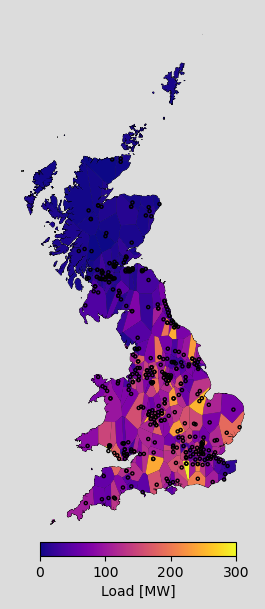

In [239]:
loads = pd.concat((regions, n.loads[['p_set']]), axis=1)

fig, ax = plt.subplots(1, 1, figsize=size)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

handles, labels = [], []

regions.plot(ax=ax, edgecolor='black', facecolor='none', alpha=1, zorder=0, linewidth=0.4)

cmap = 'plasma'

loads.plot(
    ax=ax,
    column='p_set',
    cmap=cmap,
)


s = 5
gsp_kwargs = dict(s=s, edgecolor='k', alpha=1, linewidth=1, facecolors=None)
scatter = ax.scatter(buses.x, buses.y, **gsp_kwargs)
scatter.set_facecolor('none')

from matplotlib import colors
from matplotlib import ticker

norm = colors.Normalize(vmin=loads['p_set'].min(), vmax=len(loads['p_set']))
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

cax = fig.add_axes([0.38, 0.1, 0.28, 0.02])
cb0 = fig.colorbar(cbar, cax=cax, orientation='horizontal')

locator = ticker.LinearLocator(4)
cax.xaxis.set_major_locator(locator)

# ticks = cax.get_xticks()
cax.set_xticklabels([0, 100, 200, 300])

cax.set_xlabel('Load [MW]')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('network_load.png', dpi=300)
plt.show()

In [240]:
bmus = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / 'elexon_bmus.csv', index_col=0)
# loc = pd.read_csv(Path.cwd().parent / 'data' / 'manual' / 'bmus.csv', index_col=0)
loc = pd.read_csv(Path.cwd().parent / 'resources' / 'bmunits_loc.csv', index_col=0)

shared = bmus.index.intersection(loc.index)

loc = pd.concat((bmus.loc[shared], loc.loc[shared]), axis=1).dropna()
loc = loc.loc[loc.lon != 0]

loc

,PN,MELS,lat,lon,capacity,carrier
NationalGridBmUnit,,,,,,
PETDG-1,0,38,52.575703,-0.203798,50.0,gas-fired
AG-LLIM02,0,0,51.018497,-3.157186,30.0,battery
BRGDG-1,0,48,53.540993,-0.508006,50.0,gas-fired
AG-NHAV02,24,24,55.803000,-3.781000,0.0,gas
CMSTW-1,36,46,58.406935,-3.270129,50.0,onwind
...,...,...,...,...,...,...
EDINW-1,8,42,57.279043,-6.229248,41.4,onwind
ABRBO-1,62,97,57.216700,-1.983330,96.8,offwind
PNYCW-1,16,228,51.710658,-3.561358,228.0,wind


In [241]:
print(loc.carrier.unique())

nice_carriers = {
    "gas turbine": [
        'gas-fired',
        'gas',
        'chp',
        'CCGT',
        'gas turbine',
        'natural gas processing'
        ],
    "nuclear": ['nuclear'], 
    "biomass": ['biomass'], 
    "coal": ['coal'], 
    "hydro": [
        'hydro',
        'hydro-scheme',
        'PHS',
        'dam'
        ],
    "onshore wind": ['onwind', 'wind'],
    "offshore wind": ['offwind', 'floating wing'],
    "interconnector": ['HVDC submarine'],
    "solar": ['solar power station', 'PV'],
}

carrier_colors = {
    "onshore wind": "#235ebc",
    "offshore wind": "#6895dd",
    "hydro": "#298c81",
    "coal": "#545454",
    "biomass": "#baa741",
    "gas turbine": "#a85522",
    "nuclear": '#ff8c00',
    "interconnector": "#8a1caf",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": '#ace37f',
}

['gas-fired' 'battery' 'gas' 'onwind' 'hydro' 'hydro-scheme' 'wind'
 'biomass' 'offwind' 'CHP' 'CCGT' 'floating wind' 'coal'
 'submarine power cable' 'gas turbine' 'interconnector' 'HVDC submarine'
 'cascade' 'steel mill' 'PV' 'PHS' 'nuclear' 'dam' 'solar power station'
 'natural gas processing' 'powerstation']


In [242]:
loc.loc[loc.carrier == 'coal']

,PN,MELS,lat,lon,capacity,carrier
NationalGridBmUnit,,,,,,
LNMTH-1,130,130,55.204170,-1.520830,420.0,coal
LNMTH-2,122,121,55.204170,-1.520830,420.0,coal
LNMTH-3,0,0,55.204170,-1.520830,420.0,coal
RATS-1,400,400,52.855864,-1.219482,2116.0,coal
RATS-2,0,0,52.855864,-1.219482,2116.0,coal
RATS-3,480,480,52.855864,-1.219482,2116.0,coal
RATSGT-2,0,15,52.855864,-1.219482,2116.0,coal
RATSGT-4,0,0,52.855864,-1.219482,2116.0,coal
RATS-4,450,480,52.855864,-1.219482,2116.0,coal


c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


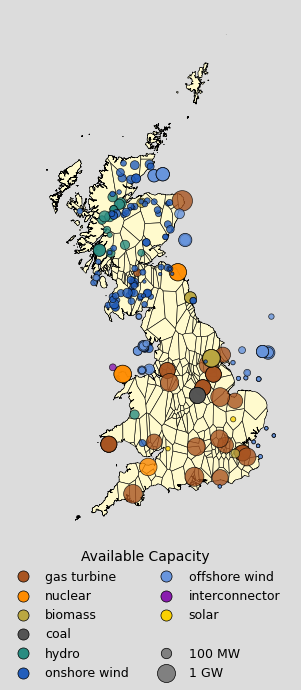

In [244]:
fig, ax = plt.subplots(1, 1, figsize=size)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

handles, labels = [], []
onegw_size = 200

regions.plot(ax=ax, edgecolor='black', facecolor='lemonchiffon', alpha=1, zorder=0, linewidth=0.4)

loc.loc[['LNMTH-1', 'LNMTH-2', 'LNMTH-3'], 'carrier'] = 'biomass'

for carrier, n_carriers in nice_carriers.items():

    loc_carrier = loc.loc[loc.carrier.isin(n_carriers)]
    if loc_carrier.empty:
        continue

    ax.scatter(
        loc_carrier.lon.tolist(),
        loc_carrier.lat.tolist(),
        s=np.sqrt(loc_carrier["PN"] / 1000) * onegw_size,
        color=carrier_colors[carrier],
        edgecolor='k',
        alpha=0.8,
        linewidth=0.5
        )

    handles.append(
        Line2D(
            [], [],
            color=background_color,
            marker='o',
            markersize=8,
            markerfacecolor=carrier_colors[carrier],
            markeredgewidth=0.5,
            markeredgecolor='black',
            )
        )
    labels.append(carrier)

"""
ax.scatter(
    loc.loc['ISG-NDPL1'].lon, 
    loc.loc['ISG-NDPL1'].lat, 
    s=onegw_size,
    color='red'
)
ax.scatter(
    loc.loc['GLNDO-1'].lon, 
    loc.loc['GLNDO-1'].lat, 
    s=np.sqrt(loc.loc['GLNDO-1', "PN"] / 1000) * onegw_size, 
    color='magenta'
)
"""

handles.append(Line2D([0], [0], color=background_color))
labels.append("")
handles.append(Line2D(
    [0], [0],
    color=background_color,
    marker='o',
    markersize=7.5,
    markerfacecolor="grey",
    markeredgewidth=0.5,
    markeredgecolor='black',
    ))
labels.append("100 MW")
handles.append(Line2D(
    [0], [0],
    color=background_color,
    marker='o',
    markersize=13,
    markerfacecolor="grey",
    markeredgewidth=0.5,
    markeredgecolor='black',
    ))
labels.append("1 GW")

ax.legend(
    handles,
    labels,
    title="Available Capacity",
    bbox_to_anchor=(0.98, 0.0),
    ncol=2,
    fontsize=9,
    borderpad=0,
    labelspacing=0.5,
    frameon=False,
)


ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("capacity.png", dpi=300)
plt.show()